### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 26th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize

### (1)

In [2]:
# (1)
# Loading hw4_data_1.npy
data = np.load("../../homeworks/hw_data/hw4_data_1.npy")
# extracting voltage measurements and uncertainties
meas = data[:,0] 
uncert = data[:,1]

# Using heteroscedastic gaussian result from derivation in Lecture 5 
# to calculate sample mean and error on sample mean 
sample_mu = np.sum(meas/uncert**2)/np.sum(1/uncert**2)
error = np.sum(1/uncert**2)**(-1/2)
print('sample mean: ',sample_mu)
print('error on sample mean:',error)

sample mean:  4.942118214425304
error on sample mean: 0.43024334605205083


### (2)

In [3]:
# (2)
# Writing ln-likelihood function for Gaussian distribution, following approach from Lecture 6 & HW_3
# For a Gaussian distribution, maximizing ln-likelihood is same as minimizing chi^2 (derivations in L5 & L6).
def squared_loss(mu, xi, sigma):
    # the only model parameter is mean value, a constant value
    return np.sum(((xi - mu) / sigma) ** 2, -1) # data minus model, weighted by the noise

# define a lambda function
f_squared = lambda beta: squared_loss(beta[0], xi=meas, sigma=uncert)

# compute the maximum likelihood 
beta0 = 5 # initial guess for mu
beta_squared = optimize.fmin(f_squared, beta0, disp=False) # scipy optimize finds the function minimum

print('Best fit mean voltage: ',beta_squared[0])

Best fit mean voltage:  4.942138671875


### (3)

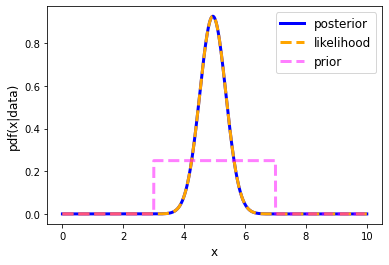

In [4]:
# (3) 
# make a grid of mu values (mean voltage values)
mu_grid = np.linspace(0,10,10000)
# assuming a uniform prior for the mean in the range 3 to 7
pri = np.repeat(1,len(mu_grid))/(7-3) 
# the prior exists only for mu values within the 3-7 range; prior should be 0 outside of that range.
# prior will limit the posterior pdf to within this range.
pri[(mu_grid<3)] = 0
pri[(mu_grid>7)] = 0

# find the likelihood
probsum = []
for i in range(len(mu_grid)):
#   can also find pdf and then take the product
    pdf = norm.pdf(meas,loc=mu_grid[i],scale=uncert) # same thing as doing 'norm(meas,uncert).pdf(mu_grid[i])'
    probsum.append(np.product(pdf))
L = np.array(probsum)

# find the Bayesian posterior probability density (not the log posterior)
post = L*pri
# normalize posterior
normal_post = post/(np.sum(post) * (mu_grid[1]-mu_grid[0]))

# plot the normalized posterior, normalized likelihood, and prior distributions
plt.plot(mu_grid, post/(np.sum(post) * (mu_grid[1]-mu_grid[0])), label='posterior',c='b',lw=3)
plt.plot(mu_grid, L/(np.sum(L) * (mu_grid[1]-mu_grid[0])), label='likelihood',c='orange',ls='--',lw=3)
plt.plot(mu_grid, pri, label='prior',c='magenta', alpha=0.5, ls='--',lw=3)
plt.xlabel('x',fontsize=12);plt.ylabel('pdf(x|data)',fontsize=12)
plt.legend(fontsize=12)
plt.show()

SRT: Very nice.

### (4)

In [5]:
# (4) 
# Find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to 
# the sample mean plus/minus the standard error, respectively. Also find the MAP value of the mean.

# drawing samples from the normalized posterior
# note: the input for 'p' must be a probability. To convert 'normal_post' to a probability,
# we must multiply by the infinitesimal '(mu_grid[1]-mu_grid[0])'. Doing 'p=post/np.sum(post)' also works.
# 'p' input must sum to 1.
samples = np.random.choice(mu_grid, size=10000, p=normal_post*(mu_grid[1]-mu_grid[0])) 
                                                                   
# using code from Lecture 10 to find 68% region and MAP value
# 68% equal-tailed credible region
lower, upper = np.percentile(samples,q=16), np.percentile(samples,q=84)
# MAP value
hist, bins = np.histogram(samples, bins=50)
bin_mid = 0.5 * (bins[1:] + bins[:-1])
idx = np.argsort(hist)[-1]
map_theta = bin_mid[idx]

# Note to self: can find the credible region by finding the ppf (the inverse cdf or 'percentile')
# hist = np.histogram(mu_grid, bins=50)
# hist_dist = scipy.stats.rv_histogram((normal_post[:-1],mu_grid))
# ppf = hist_dist.ppf(0.84) # or 0.16
# And for MAP, substituting 'samples' with 'normal_post', & 'bins' with 'mu_grid'

print('68% credible region = ' + str(lower) + ' to ' + str(upper))
print('While sample mean plus/minus the standard error:')
print(str(sample_mu-error),'to',str(sample_mu+error))
print('MAP value of the mean = ' + str(map_theta))

68% credible region = 4.508450845084509 to 5.375537553755375
While sample mean plus/minus the standard error:
4.511874868373253 to 5.372361560477355
MAP value of the mean = 4.911811181118112


SRT: Very novel! I've never used np.random.choice in this way.

### (5)

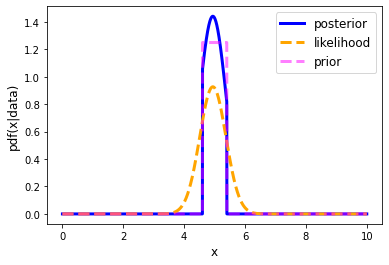

68% credible region = 4.735473547354736 to 5.239523952395239
While sample mean plus/minus the standard error:
4.511874868373253 to 5.372361560477355
MAP value of the mean= 4.864156415641563


In [6]:
# (5) 
# Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4.

# following same procedure as (3)
pri = np.repeat(1,len(mu_grid))/(5.4-4.6)
# the prior exists only for mu values within the 3-7 range; prior should be 0 outside of that range.
pri[(mu_grid<4.6)] = 0
pri[(mu_grid>5.4)] = 0 

post2 = L*pri
normal_post2 = post2/(np.sum(post2) * (mu_grid[1]-mu_grid[0]))

plt.plot(mu_grid, normal_post2, label='posterior',c='b',lw=3)
plt.plot(mu_grid, L/(np.sum(L) * (mu_grid[1]-mu_grid[0])), label='likelihood',c='orange',ls='--',lw=3)
plt.plot(mu_grid, pri, label='prior',c='magenta',alpha=0.5,ls='--',lw=3)
plt.xlabel('x',fontsize=12);plt.ylabel('pdf(x|data)',fontsize=12)
plt.legend(fontsize=12)
plt.show()

# following same procedure as (4)
# drawing samples from the normalized posterior to find 68% credible region and MAP value
samples = np.random.choice(mu_grid, size=10000, p=normal_post2*(mu_grid[1]-mu_grid[0])) 
                                                                   
# 68% equal-tailed credible region
lower, upper = np.percentile(samples,q=16), np.percentile(samples,q=84)
# MAP value
hist, bins = np.histogram(samples, bins=50)
bin_mid = 0.5 * (bins[1:] + bins[:-1])
idx = np.argsort(hist)[-1]
map_theta = bin_mid[idx]

print('68% credible region = ' + str(lower) + ' to ' + str(upper))
print('While sample mean plus/minus the standard error:')
print(str(sample_mu-error),'to',str(sample_mu+error))
print('MAP value of the mean= ' + str(map_theta))

### (6)

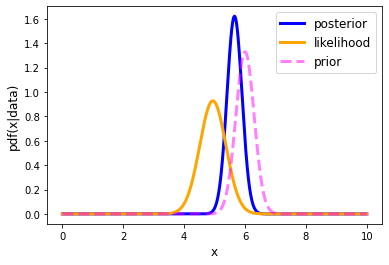

68% credible region = 5.40954095409541 to 5.8945894589458945
While sample mean plus/minus the standard error:
4.511874868373253 to 5.372361560477355
MAP value of the mean= 5.7419341934193415


In [8]:
# (6)  
# Repeat (3) and (4) this time with a Gaussian prior on the mean centered at 6 with standard deviation of 0.3

# following similar procedure to (3)
# gaussian prior on mu centered at 6 with std of 0.3
pri = norm.pdf(mu_grid,6,0.3)

post3 = L*pri
normal_post3 = post3/(np.sum(post3) * (mu_grid[1]-mu_grid[0]))

plt.plot(mu_grid, normal_post3, label='posterior',c='b',lw=3)
plt.plot(mu_grid, L/(np.sum(L) * (mu_grid[1]-mu_grid[0])), label='likelihood',c='orange',lw=3)
plt.plot(mu_grid, pri, label='prior',c='magenta', alpha=0.5, ls='--',lw=3)
plt.xlabel('x',fontsize=12);plt.ylabel('pdf(x|data)',fontsize=12)
plt.legend(fontsize=12)
plt.show()

# following same procedure as (4)
# drawing samples from the normalized posterior to find 68% credible region and MAP value
samples = np.random.choice(mu_grid, size=10000, p=normal_post3*(mu_grid[1]-mu_grid[0])) 
                                                                   
# 68% equal-tailed credible region
lower, upper = np.percentile(samples,q=16), np.percentile(samples,q=84)
# MAP value
hist, bins = np.histogram(samples, bins=50)
bin_mid = 0.5 * (bins[1:] + bins[:-1])
idx = np.argsort(hist)[-1]
map_theta = bin_mid[idx]

print('68% credible region = ' + str(lower) + ' to ' + str(upper))
print('While sample mean plus/minus the standard error:')
print(str(sample_mu-error),'to',str(sample_mu+error))
print('MAP value of the mean= ' + str(map_theta))

SRT: Excellent, Niana.

### (7)

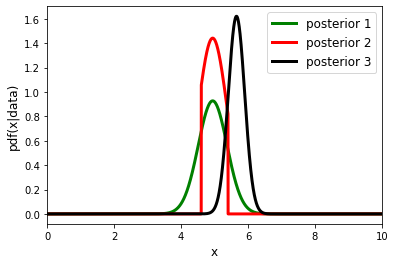

In [9]:
# (7) 
# Plot all of the normalized posterior pdfs for  𝜇  from (3), (5), and (6) on the same plot, making sure 
# that the xlim of the plot spans 0 to 10.

plt.plot(mu_grid, normal_post, label='posterior 1',c='g',lw=3)
plt.plot(mu_grid, normal_post2, label='posterior 2',c='r',lw=3)
plt.plot(mu_grid, normal_post3, label='posterior 3',c='k',lw=3)
plt.xlabel('x',fontsize=12);plt.ylabel('pdf(x|data)',fontsize=12)
plt.legend(fontsize=12)
plt.xlim(0,10)
plt.show()

### (8)

In [12]:
# (8)
# Bayesian evidence and Bayes factor

# The normalization constant used to normalize the posterior pdfs in previous cells is the Bayesian evidence 
# for the particular model applied.
evidence1 = np.sum(post) * (mu_grid[1]-mu_grid[0])

# Computing the evidence under a new model where the prior for the mean is a delta function at the best-fit value 
# found in (2).
from scipy import signal

# finding the closest element to 'beta_squared[0]' in the mu_grid array
value = beta_squared[0]
absolute_val_array = np.abs(mu_grid - value)
smallest_difference_index = absolute_val_array.argmin()
closest_element = mu_grid[smallest_difference_index]
idx = smallest_difference_index

# prior for the mean is a delta function at the best-fit value found in (2)
# the delta function=1, and 0 everywhere that it's not the value at 'mu_grid[idx]'
prior = signal.unit_impulse(len(mu_grid),idx) 

# find the posterior using this new prior
post_new = L*prior

# The sum of 'post_new' should be the Bayesian evidence for this model.
# Note to self: don't need to include the infinitesimal in evidence calculation; the delta function is 
# already normalized so that it takes into account that infinitesimal.
# Will get the same thing if we find the likelihood at the location of the delta function spike 'L[idx]',
# or find the posterior pdf at the position of the delta function 'post_new[idx]'. 
# i.e., Evidence = np.sum(post_new) == L[idx] == post_new[idx]
evidence2 = np.sum(post_new) #* (mu_grid[1]-mu_grid[0])
print('Evidence under uniform prior:',evidence1)
print('Evidence under delta fcn. prior:',evidence2)

# Taking ratios to make a Bayes factor, to see which model is favored?
odds = evidence1/evidence2
print('\nBayes factor (B12) = ',odds,
      '\n\nModel under Delta function prior (model 2) is more probable than model under Uniform prior (model 1).')
print('Think makes sense because the delta function gives the exact mean, and should therefore be the better model.')

# Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly?

# Note to self: From Lecture 9, Occam penalty: All else being equal, the less complex model is favored.
# The model that has no free parameters (the one that's a delta function at the true value) is going to be better 
# than one where we're searching over a wide prior range for this parameter. The evidence is going to be higher
# whenever we know exactly what the parameter is compared to having to search over it.
print('Regarding Occam penalty: The model with the delta function prior (the less complex model) is favored.',
     'This proof of that lies in that the evidence under the delta function prior is higher than that under a',
     'uniform prior.')

Evidence under uniform prior: 2.8918714615457667e-08
Evidence under delta fcn. prior: 1.0725967252258747e-07

Bayes factor (B12) =  0.2696140491140113 

Model under Delta function prior (model 2) is more probable than model under Uniform prior (model 1).
Think makes sense because the delta function gives the exact mean, and should therefore be the better model.
Regarding Occam penalty: The model with the delta function prior (the less complex model) is favored. This proof of that lies in that the evidence under the delta function prior is higher than that under a uniform prior.


SRT: Excellent work.

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in the lecture. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [13]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

### Solution

### (1)

In [14]:
# (1) Read in hw4_data_2.npy, a (3 x 20) numpy array that you used in Lecture_9.
data2 = np.load("../../homeworks/hw_data/hw4_data_2.npy")
# x, y, sigma_y = data2

### (2)

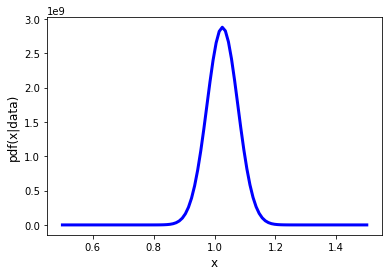

In [22]:
# (2) 
# using the given functions to compute the un-normalized posterior pdf on a grid of the linear coefficient 
# of a linear model, with a uniform prior between 0.5 and 1.5.

# a uniform prior for the linear coefficient (the slope) between 0.5 and 1.5
pri = np.repeat(1,100)/(1.5-0.5)

# make an array of 'theta' values based on the prior range; this is a grid of the linear coefficient (the slope)
xgrid = np.linspace(0.5,1.5,100)

# find the posterior pdf
logls = []
for i in xgrid:
    # keeping the y-intercept fixed at −0.23, but changing the slope values
    thetas = np.array([-0.23,i]) # np.concatenate(([-0.23], i), axis=None)
    likelihood = logL(thetas, data2, model=polynomial_fit)
    logls.append(likelihood)
    
# Find posterior pdf; take the log prior in order to sum with log likelihood
# this is just a one-dimensional model because the y-intercept is fixed.
posterior = np.log(np.repeat(1,100)/(1.5-0.5))+logls
# switching out of log space
posterior = np.exp(posterior)

# plot the posterior pdf
plt.plot(xgrid,posterior,c='b',lw=3)
plt.xlabel('x',fontsize=12);plt.ylabel('pdf(x|data)',fontsize=12)
plt.show()

### (3)

In [16]:
# (3) 
# Using the 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. 
# Bayesian evidence is the integral (sum) of likelihood-x-prior, times the infinitesimal
b_1D_evidence = np.sum(posterior)*(xgrid[1]-xgrid[0])
print('Bayesian evidence = ',b_1D_evidence) 

Bayesian evidence =  365684733.1606578


SRT: Good.

### (4)

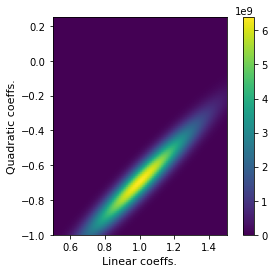

In [23]:
# (4) 
# Compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic 
# coefficients of a quadratic model.

# uniform priors for the linear coefficient are between 0.5 and 1.5, & quadratic coefficient between -1 and 0.25
lin_prior = np.repeat(1,100)/(1.5-0.5)
quad_prior = np.repeat(1,100)/(0.25-(-1))
xgrid = np.linspace(0.5,1.5,100) # linear coefficients
xgrid2 = np.linspace(-1,0.25,100) # quadratic coefficients

# Finding the joint 2D posterior pdf of a quadratic model
posterior_2d = []
posterior_matrix = []
q_lnlike = []
for i in range(len(xgrid)):
    posterior_2d = []
    for j in range(len(xgrid)):
        theta_quad = np.array([-0.23,xgrid[i],xgrid2[j]])
        q_likelihood = logL(theta_quad, data2, model=polynomial_fit)
        q_lnlike.append(q_likelihood)
        posts = np.log(quad_prior[j])+np.log(lin_prior[i])+q_likelihood
        # make sure to switch out of log space
        posterior_2d.append(np.exp(posts))
#   this is a two-dimensional model because the y-intercept is fixed.
    posterior_matrix.append(posterior_2d)
# np.shape(posterior_matrix) should be 100-x-100

# Plot this two-dimensional posterior
# Note: x an y axes are the indices of the array elements. Use 'extent' argument to 
# replace with actual coordinates of the linear & quad. coefficients.
plt.imshow(posterior_matrix,
           extent = [np.amin(xgrid),np.amax(xgrid),np.amin(xgrid2),np.amax(xgrid2)]) #cmap="copper_r"
plt.colorbar()
plt.xlabel('Linear coeffs.', fontsize=11)
plt.ylabel('Quadratic coeffs.', fontsize=11)
plt.show()

### (5)

In [18]:
# (5) 
# Using the 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model.
b_2D_evidence = np.sum(posterior_matrix)*(xgrid[1]-xgrid[0])*(xgrid2[1]-xgrid2[0])
print('Bayesian evidence = ',b_2D_evidence)

Bayesian evidence =  493061001.6570572


### (6)

In [20]:
# (6) Calculate the Bayes factor for a linear versus quadratic model. 
print('Bayes factor (B12) = ',b_1D_evidence/b_2D_evidence)
print('Quadratic model (model 2) is more probable than Linear model (model 1).')

# Compare/contrast with the BIC model comparison in the lecture?
# BIC model comparison: the model with the smaller BIC value wins (Lecture 9)
# BIC≡−2ln[𝐿0(𝑀)]+𝑘ln𝑁, where 𝑁 = data points, 𝑘 = parameters, 𝐿0(𝑀) = max value of likelihood
print('\nBIC for linear model',-2*np.amax(logls)+1*np.log(len(logls)))
print('BIC for quadratic model',-2*np.amax(q_lnlike)+2*np.log(len(q_lnlike)))
print('The BIC is more severe than Bayesian evidence in penalizing parameters. And the BIC results here suggest',
    "that the linear model is better. But since this exercise is computationally feasible, its better to compute",
    "and rely on the odds ratio; which tells us that the Quadratic model is favored.")

Bayes factor (B12) =  0.7416622526050144
Quadratic model (model 2) is more probable than Linear model (model 1).

BIC for linear model -38.95553992520727
BIC for quadratic model -27.179045185730892
The BIC is more severe than Bayesian evidence in penalizing parameters. And the BIC results here suggest that the linear model is better. But since this exercise is computationally feasible, its better to compute and rely on the odds ratio; which tells us that the Quadratic model is favored.


SRT: All correct, and good commentary Niana. Well done.